# Visualization

In [3]:
from keras.models import load_model

Using TensorFlow backend.


In [4]:
model = load_model('models/cats_and_dogs_small_1.h5')

In [5]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

## path

In [6]:
img_path = 'Data/test/cats/cat.{}.jpg'.format(1700)

In [7]:
from keras.preprocessing import image
import numpy as np

In [8]:
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
print('Before', img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
print('After', img_tensor.shape)
img_tensor /= 255.

Before (150, 150, 3)
After (1, 150, 150, 3)


## Init plotting

In [9]:
import matplotlib.pyplot as plt

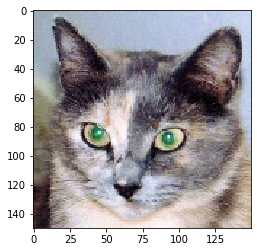

In [10]:
plt.imshow(img_tensor[0])

# Tensors

In [11]:
from keras import models

In [12]:
layer_outputs = [layer.output for layer in model.layers[:8]]

In [13]:
layer_outputs

[<tf.Tensor 'conv2d_12/Relu:0' shape=(None, 148, 148, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d_6/MaxPool:0' shape=(None, 74, 74, 32) dtype=float32>,
 <tf.Tensor 'conv2d_13/Relu:0' shape=(None, 72, 72, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_7/MaxPool:0' shape=(None, 36, 36, 64) dtype=float32>,
 <tf.Tensor 'conv2d_14/Relu:0' shape=(None, 34, 34, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_8/MaxPool:0' shape=(None, 17, 17, 128) dtype=float32>,
 <tf.Tensor 'conv2d_15/Relu:0' shape=(None, 15, 15, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_9/MaxPool:0' shape=(None, 7, 7, 128) dtype=float32>]

In [14]:
model.input

<tf.Tensor 'conv2d_12_input:0' shape=(None, 150, 150, 3) dtype=float32>

In [15]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [16]:
activations = activation_model.predict(img_tensor)

In [17]:
len(activations)

8

In [18]:
first_layer_activation = activations[0]

In [19]:
first_layer_activation.shape

(1, 148, 148, 32)

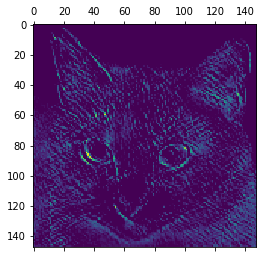

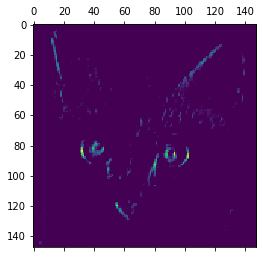

In [20]:
plt.matshow(first_layer_activation[0, :, :, 4])
plt.matshow(first_layer_activation[0, :, :, 7])

The first is about diagonal detection<br>
The seconds is detecting green eyes

## Each channel

In [21]:
layers_names = []
for layer in model.layers[:8]:
    layers_names.append(layer.name)
print(layers_names)

['conv2d_12', 'max_pooling2d_6', 'conv2d_13', 'max_pooling2d_7', 'conv2d_14', 'max_pooling2d_8', 'conv2d_15', 'max_pooling2d_9']


In [22]:
images_per_row = 16

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


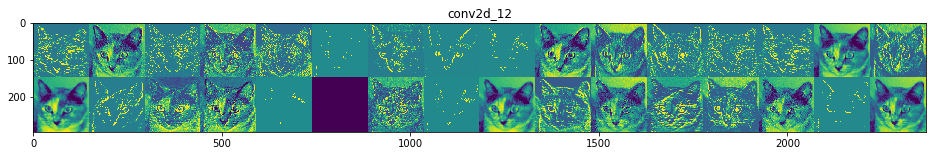

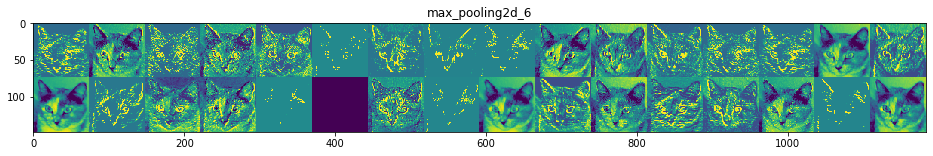

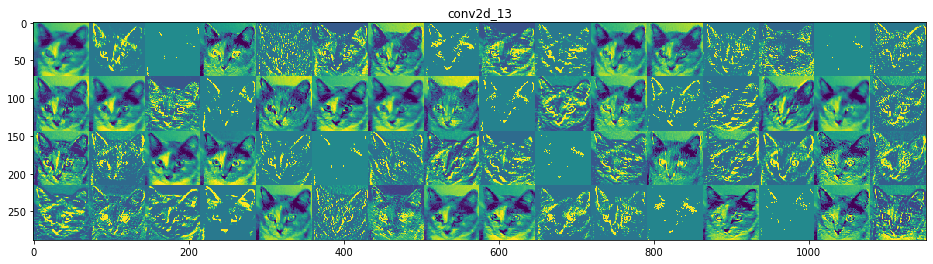

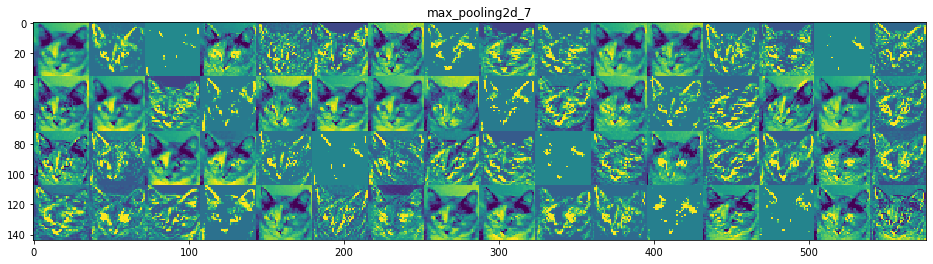

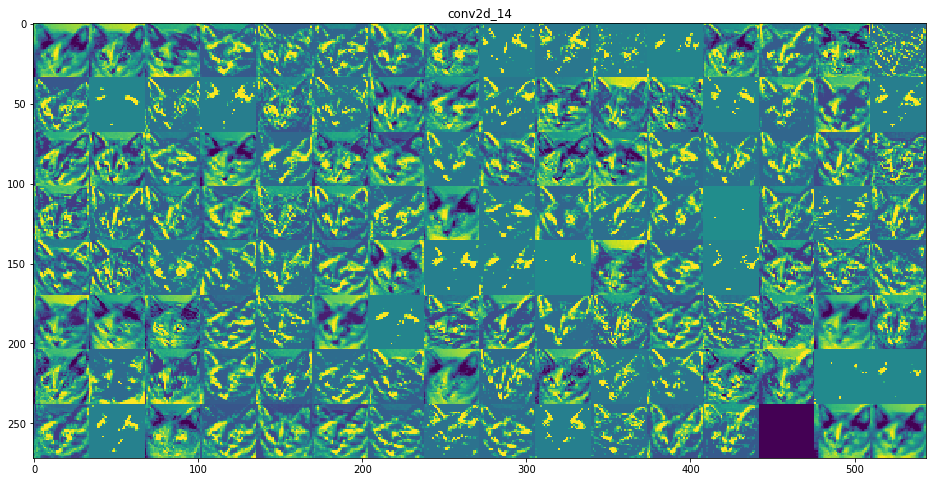

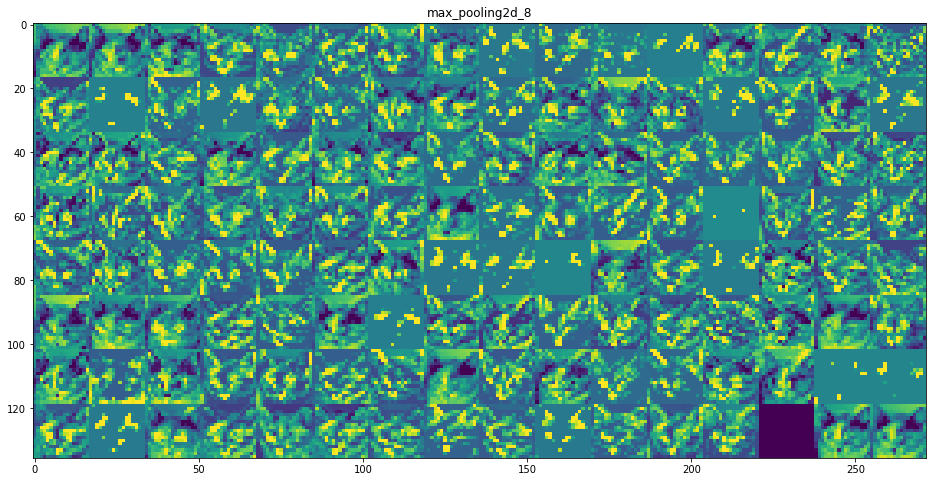

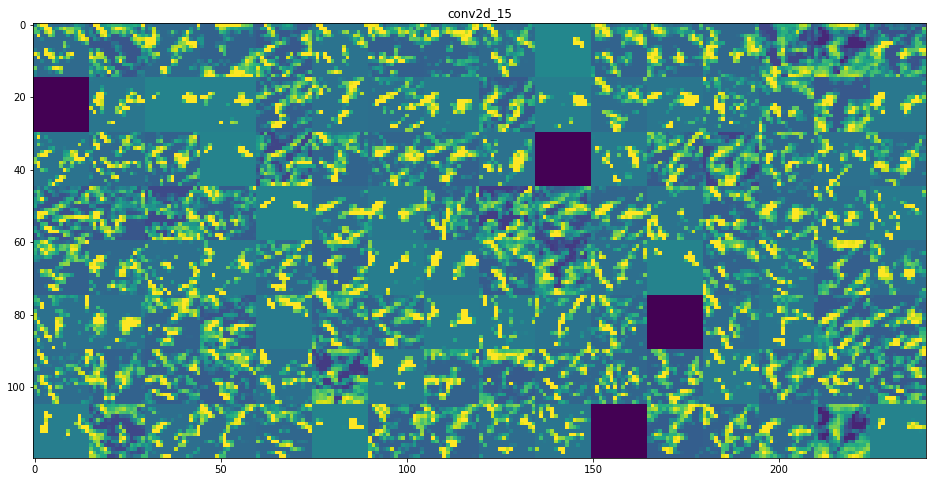

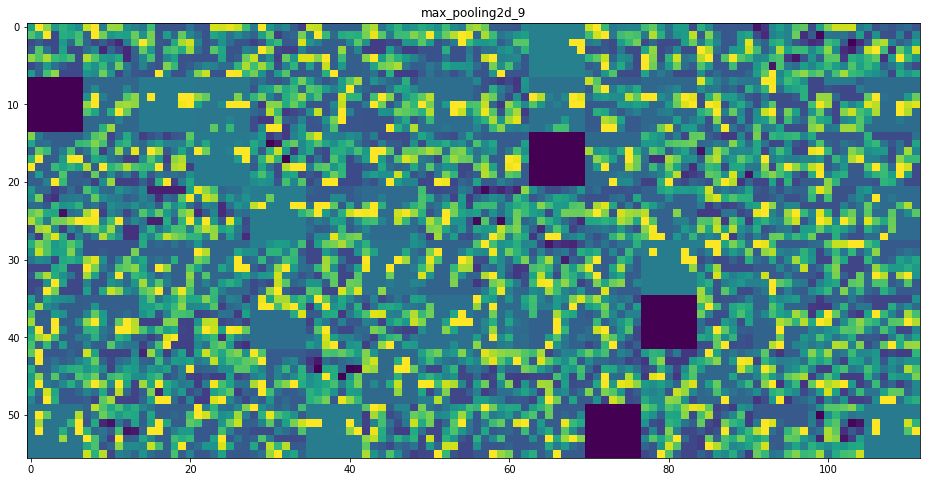

In [23]:
for layer_name, layer_activation in zip(layers_names, activations):
    n_features = layer_activation.shape[-1]  # first layer (1, 148, 148, 32)
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size)) 
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image +=128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size: (col+1) * size,
                       row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Now filters

In [24]:
from keras.applications import VGG16
from keras import backend as K

In [25]:
model = VGG16(weights='imagenet', include_top=False)

In [26]:
layer_name = 'block3_conv1'

In [27]:
filter_index = 0

In [28]:
layer_output = model.get_layer(layer_name).output

In [29]:
loss = K.mean(layer_output[:, :, :, filter_index])

In [30]:
grads = K.gradients(loss, model.input)[0]

In [31]:
grads

<tf.Tensor 'gradients_1/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

In [32]:
# L2 norm
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [33]:
iterate = K.function([model.input], [loss, grads])

In [34]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [35]:
# Gradient Descent
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

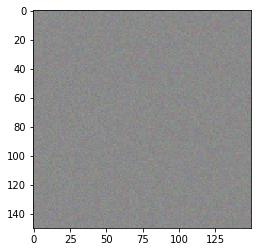

In [36]:
plt.imshow(input_img_data.reshape(150, 150, 3).astype('int'))

In [37]:
step = 1

In [38]:
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [39]:
# values may be more than 255 or less than 0
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [40]:
def generate_patter(layer_name, filter_index, size=150):
    
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
        
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1
    
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])

        input_img_data += grads_value * step
        pass
    
    img = input_img_data[0]
    return deprocess_image(img)

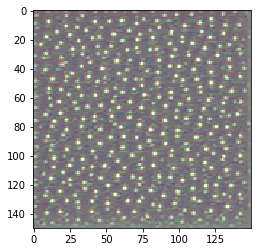

In [41]:
plt.imshow(generate_patter('block3_conv1', 0))

## Now all 

In [42]:
layer_name = 'block5_conv1'
size = 64
margin = 5

In [43]:
results = np.zeros((8*size + 7 * margin, 8*size + 7*margin, 3))

In [44]:
for i in range(8):
    for j in range(8):
        filter_img = generate_patter(layer_name, i + (j*8), size=size)
        
        horizontal_start = i*size + i*margin
        horizontal_end = horizontal_start + size        
        vertical_start = j*size + j*margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end,
               vertical_start: vertical_end, :] = filter_img
        pass
    pass

In [45]:
results = results.astype('uint8')

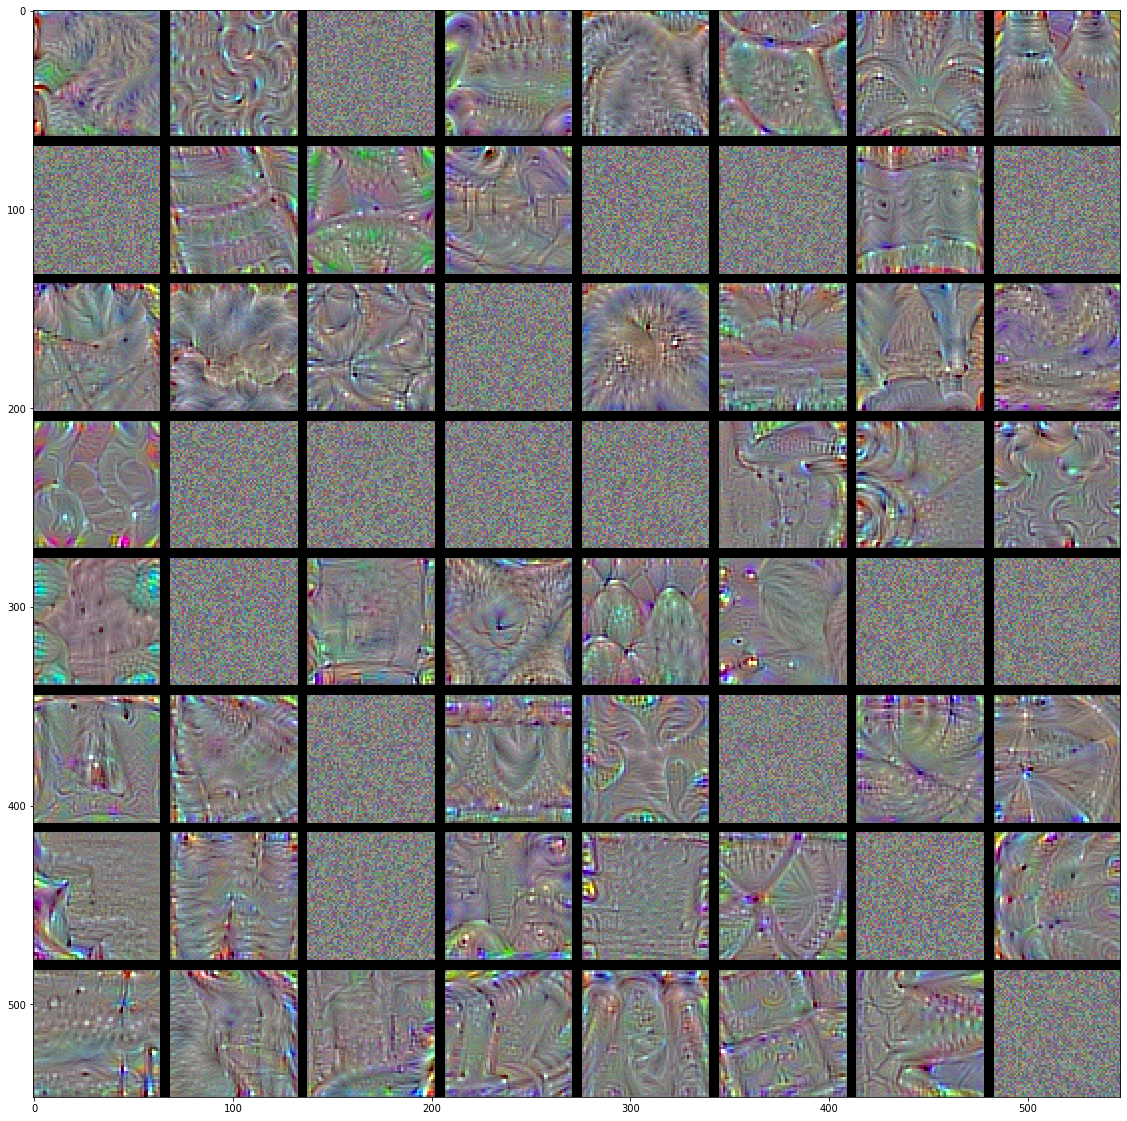

In [46]:
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.savefig(layer_name, format='svg')

# Heatmap activations

In [47]:
model = VGG16(weights='imagenet')

## to 224x224

In [48]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [49]:
img_path = 'Data/creative_commons_elephant.jpg'

In [50]:
img = image.load_img(img_path, target_size=(224,224))

In [51]:
x = image.img_to_array(img)

In [52]:
x = np.expand_dims(x, axis=0) # or just reshape(1, 224, 224, 3)

In [53]:
x = preprocess_input(x) # normalizing color channels

# to the net

In [54]:
preds = model.predict(x)

In [55]:
print('Model predicted: \n', [i[1:3] for i in decode_predictions(preds, top=3)[0]])

Model predicted: 
 [('African_elephant', 0.89544886), ('tusker', 0.09967599), ('Indian_elephant', 0.0046395455)]


In [56]:
np.argmax(preds[0])

386

## Grad - Cam

In [57]:
african_elephant_output = model.output[:, 386]

In [58]:
last_conv_layer = model.get_layer('block5_conv3')

In [59]:
last_conv_layer.kernel_size

(3, 3)

In [60]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

In [61]:
pooled_grads = K.mean(grads, axis=(0,1,2))

In [62]:
iterate = K.function([model.input],
                    [pooled_grads, last_conv_layer.output[0]])

In [63]:
pooled_grads_value, conv_layer_output_value = iterate([x])

In [64]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [65]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

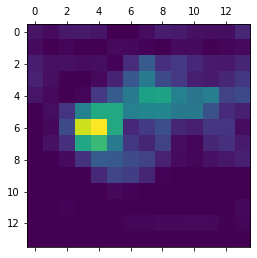

In [66]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [67]:
import cv2

In [68]:
img = cv2.imread(img_path)

In [69]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [70]:
heatmap = np.uint8(255 * heatmap)

In [71]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [72]:
imposed_img = heatmap * 0.4 + img #blure it a bit

In [73]:
cv2.imwrite('Data/creative_elephat.jpg', imposed_img)

True

<img src='Data/creative_elephat.jpg'>